# Load in data

In [1]:
# import pandas numpy and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# format display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

In [95]:
# cell usually takes 40 sec to run

# read in the data
root = 'data/'
train = pd.read_parquet(root + 'train_series.parquet')
test = pd.read_parquet(root + 'test_series.parquet')
events = pd.read_csv(root + 'train_events.csv')
submission = pd.read_csv(root + 'sample_submission.csv')

# Inspect some data

In [3]:
# convert 'timestamp' column to datetime
# train['timestamp'] = pd.to_datetime(train['timestamp'])
# test['timestamp'] = pd.to_datetime(test['timestamp'])
# events['timestamp'] = pd.to_datetime(events['timestamp'])

## Training data

In [4]:
# look at first few rows of train
train.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.637,0.022
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.637,0.022
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637,0.022
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.637,0.021
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.637,0.022


In [5]:
# dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB


In [6]:
train.shape

(127946340, 5)

In [7]:
# look at nulls
train.isna().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

__127m__ rows (no nulls) where each row represents a user at a 5-second interval.

---

Columns are as follows:
- __<ins>series_id</ins>__: unique id for each user
- __<ins>step</ins>__: time step (0 is moment that user began using device) 
- __<ins>timestamp</ins>__: time of event
- __<ins>anglez</ins>__: "z-angle". Angle of arm relative to the vertical axis of the body
- __<ins>enmo</ins>__: quantifies physical activity. Very low values (close to 0) indicate sleep or rest


In [8]:
# unique series_id
train['series_id'].nunique()

277

- 277 unique users

## Events
- essentially the labels for the training data

In [9]:
events.head(10)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.000,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.000,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.000,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.000,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.000,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.000,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.000,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.000,2018-08-18T06:48:00-0400
8,038441c925bb,5,onset,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN


In [10]:
events.shape

(14508, 5)

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


In [12]:
# look at unique events in event
events['event'].unique()

array(['onset', 'wakeup'], dtype=object)

- __14.5k rows__. Half are onset times, half are wakeup times. __7254 total days__, about __4800 days__ of training data with labels (non null)
- Each user has a onset and wakeup time once per day
- Null values in the step and timestamp cols indicate that no sleep was detected (device wasn't worn)

In [96]:
# group rows by user
events_grouped = events.groupby('series_id')

# add tot_nights col equal to last 'night' value for each series_id
events['tot_nights'] = events_grouped['night'].transform('last')

# add missing sleep column
events['missing_sleep'] = events.step.isna()

# add tot_nights_missed, divide by 2 because each night is 2 rows
events['tot_nights_missed'] = events_grouped['missing_sleep'].transform('sum').div(2).astype(int)

In [14]:
# check
events.head()

,series_id,night,event,step,timestamp,tot_nights,missing_sleep,tot_nights_missed
0,038441c925bb,1,onset,4992.000,2018-08-14T22:26:00-0400,23,False,4
1,038441c925bb,1,wakeup,10932.000,2018-08-15T06:41:00-0400,23,False,4
2,038441c925bb,2,onset,20244.000,2018-08-15T19:37:00-0400,23,False,4
3,038441c925bb,2,wakeup,27492.000,2018-08-16T05:41:00-0400,23,False,4
4,038441c925bb,3,onset,39996.000,2018-08-16T23:03:00-0400,23,False,4


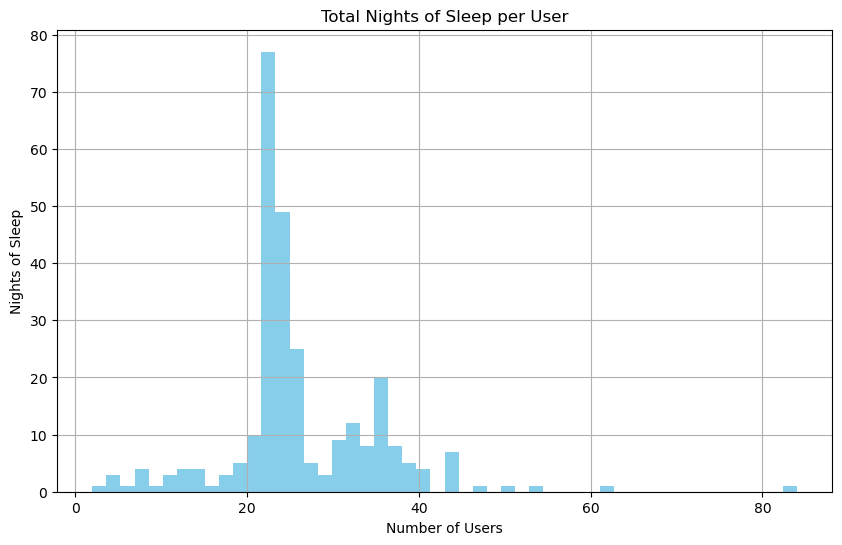

In [15]:
# plot nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
events_grouped['tot_nights'].mean().hist(bins=50, ax=ax, color='skyblue')
ax.set_title('Total Nights of Sleep per User')
ax.set_ylabel('Nights of Sleep')
ax.set_xlabel('Number of Users');

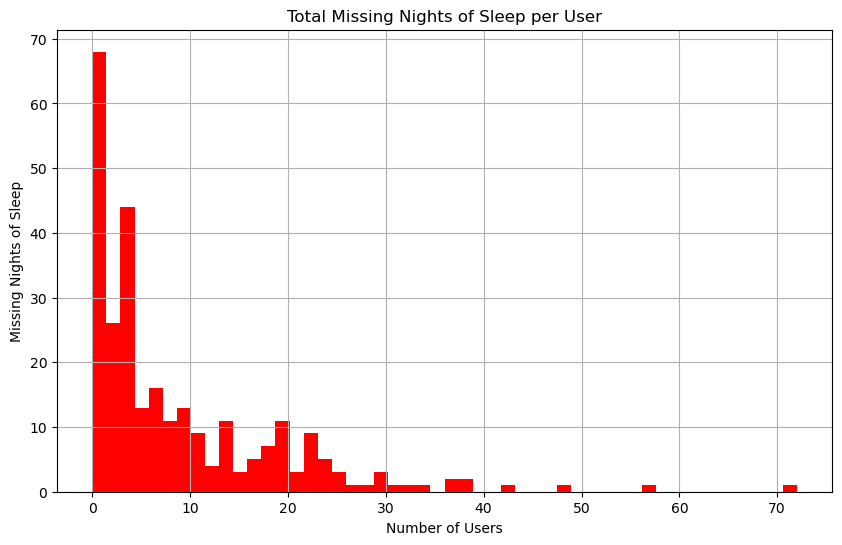

In [16]:
# plot missing nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
events_grouped['tot_nights_missed'].mean().hist(bins=50, ax=ax, color='red')
ax.set_title('Total Missing Nights of Sleep per User')
ax.set_ylabel('Missing Nights of Sleep')
ax.set_xlabel('Number of Users');

In [17]:
# look at users with most missing nights of sleep
events_grouped['tot_nights_missed'].mean().sort_values(ascending=False).head()

series_id
78569a801a38   72.000
f564985ab692   57.000
fb223ed2278c   48.000
c107b5789660   42.000
cfeb11428dd7   38.000
Name: tot_nights_missed, dtype: float64

In [18]:
# user with most missed sleep: recorded first 12 nights, then missed 72
events[(events['series_id'] == '78569a801a38') & (events['event'] == 'onset')].head(100)

,series_id,night,event,step,timestamp,tot_nights,missing_sleep,tot_nights_missed
6456,78569a801a38,1,onset,5496.000,2017-08-18T00:23:00-0400,84,False,72
6458,78569a801a38,2,onset,22488.000,2017-08-18T23:59:00-0400,84,False,72
6460,78569a801a38,3,onset,42192.000,2017-08-20T03:21:00-0400,84,False,72
6462,78569a801a38,4,onset,57924.000,2017-08-21T01:12:00-0400,84,False,72
6464,78569a801a38,5,onset,74364.000,2017-08-22T00:02:00-0400,84,False,72
6466,78569a801a38,6,onset,92280.000,2017-08-23T00:55:00-0400,84,False,72
6468,78569a801a38,7,onset,108960.000,2017-08-24T00:05:00-0400,84,False,72
6470,78569a801a38,8,onset,125760.000,2017-08-24T23:25:00-0400,84,False,72
6472,78569a801a38,9,onset,143028.000,2017-08-25T23:24:00-0400,84,False,72
6474,78569a801a38,10,onset,160596.000,2017-08-26T23:48:00-0400,84,False,72


- In the end, we may be able to drop all missing rows

# Visualize
- Look at anglez and enmo on different days for a specific user

In [118]:
# get a single user, convert to datetime
example_user = '038441c925bb'
train_example = train.loc[train['series_id'] == example_user]
train_example['timestamp'] = pd.to_datetime(train_example['timestamp'], utc=False)

# create date col for plotting
train_example['date'] = train_example['timestamp'].dt.date

C:\Users\heefj\AppData\Local\Temp\ipykernel_8260\3238233813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_example['timestamp'] = pd.to_datetime(train_example['timestamp'], utc=False)
C:\Users\heefj\AppData\Local\Temp\ipykernel_8260\3238233813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_example['date'] = train_example['timestamp'].dt.date


In [121]:
# check
train_example.head()

,series_id,step,timestamp,anglez,enmo,date
0,038441c925bb,0,2018-08-14 15:30:00-04:00,2.637,0.022,2018-08-14
1,038441c925bb,1,2018-08-14 15:30:05-04:00,2.637,0.022,2018-08-14
2,038441c925bb,2,2018-08-14 15:30:10-04:00,2.637,0.022,2018-08-14
3,038441c925bb,3,2018-08-14 15:30:15-04:00,2.637,0.021,2018-08-14
4,038441c925bb,4,2018-08-14 15:30:20-04:00,2.637,0.022,2018-08-14


In [99]:
# look at user's labels in events table
events[events['series_id'] == example_user]

,series_id,night,event,step,timestamp,tot_nights,missing_sleep,tot_nights_missed
0,038441c925bb,1,onset,4992.000,2018-08-14T22:26:00-0400,23,False,4
1,038441c925bb,1,wakeup,10932.000,2018-08-15T06:41:00-0400,23,False,4
2,038441c925bb,2,onset,20244.000,2018-08-15T19:37:00-0400,23,False,4
3,038441c925bb,2,wakeup,27492.000,2018-08-16T05:41:00-0400,23,False,4
4,038441c925bb,3,onset,39996.000,2018-08-16T23:03:00-0400,23,False,4
5,038441c925bb,3,wakeup,44400.000,2018-08-17T05:10:00-0400,23,False,4
6,038441c925bb,4,onset,57240.000,2018-08-17T23:00:00-0400,23,False,4
7,038441c925bb,4,wakeup,62856.000,2018-08-18T06:48:00-0400,23,False,4
8,038441c925bb,5,onset,NaN,NaN,23,True,4
9,038441c925bb,5,wakeup,NaN,NaN,23,True,4


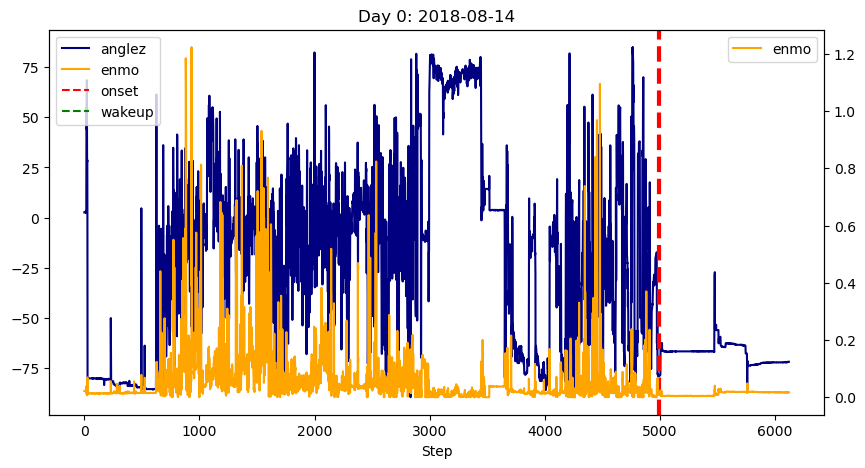

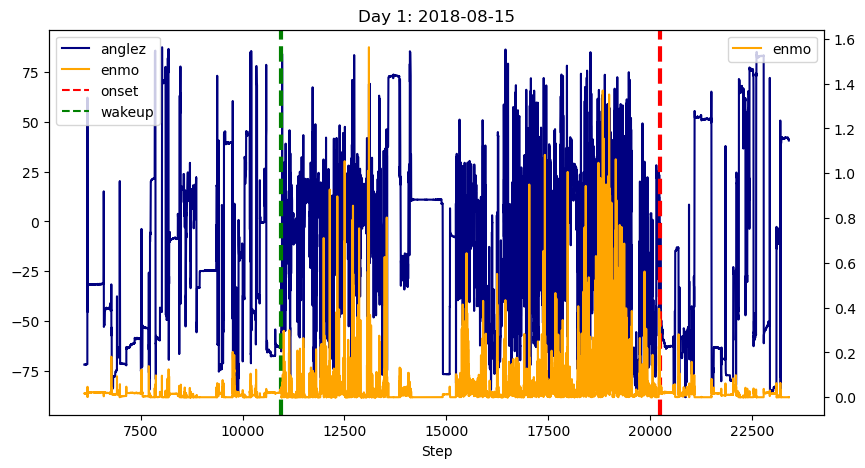

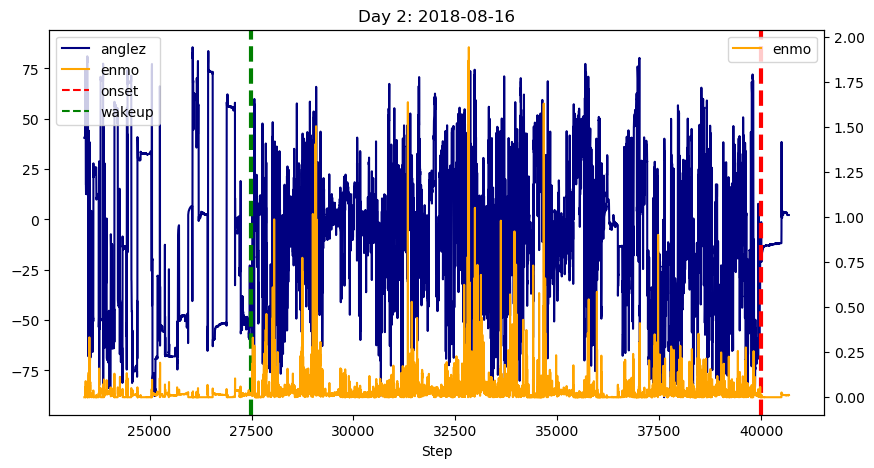

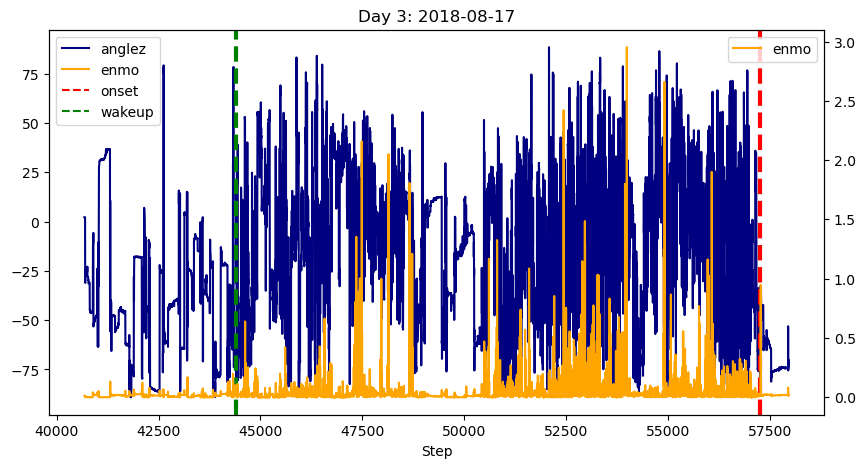

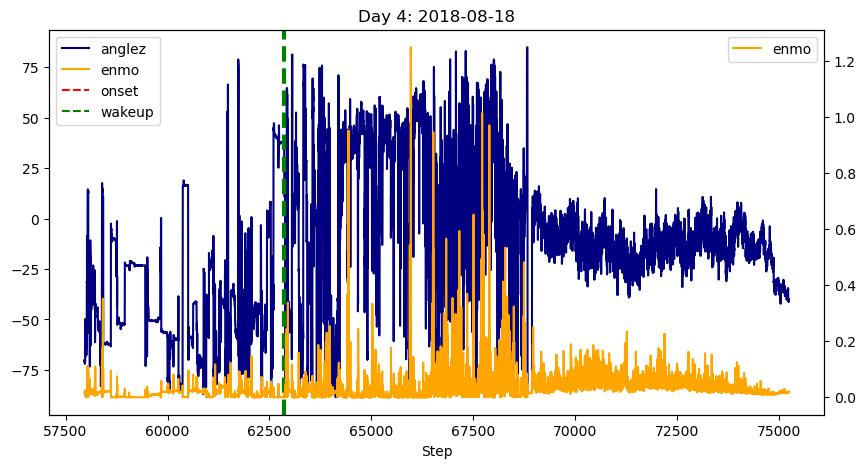

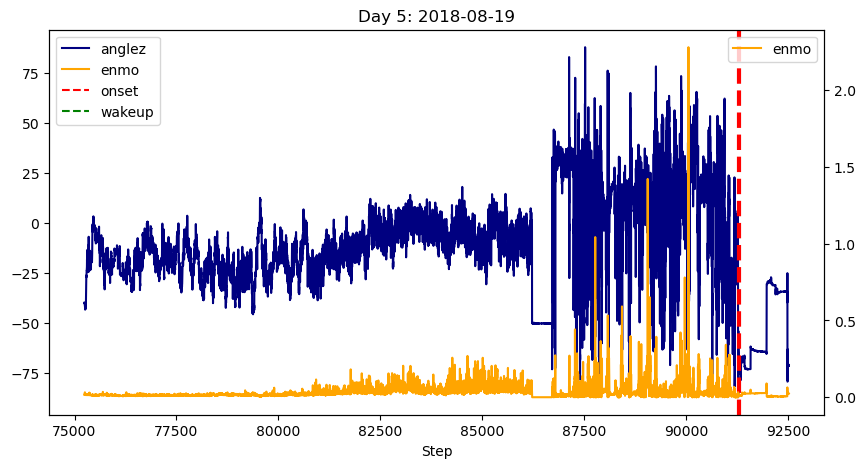

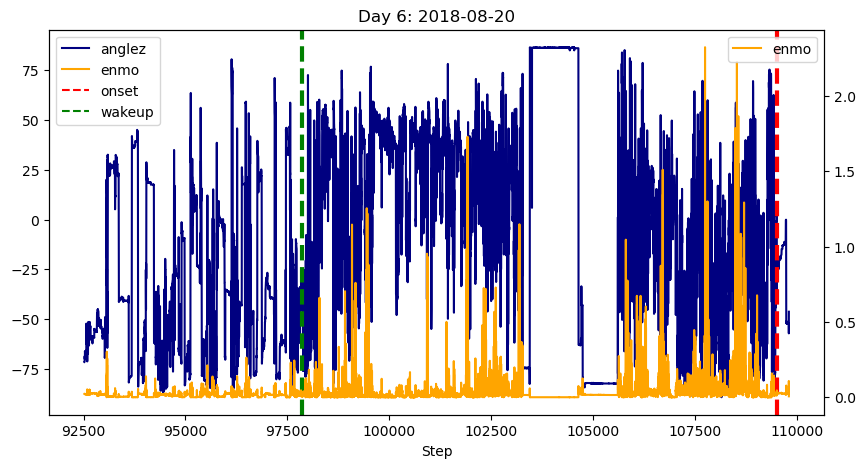

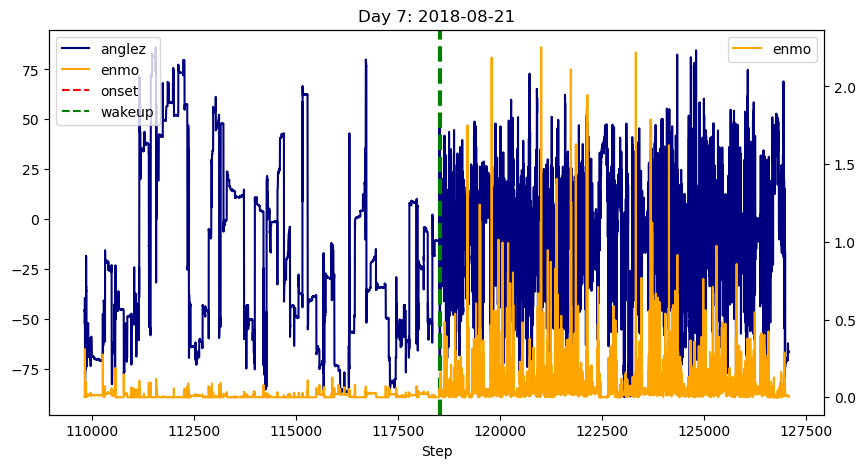

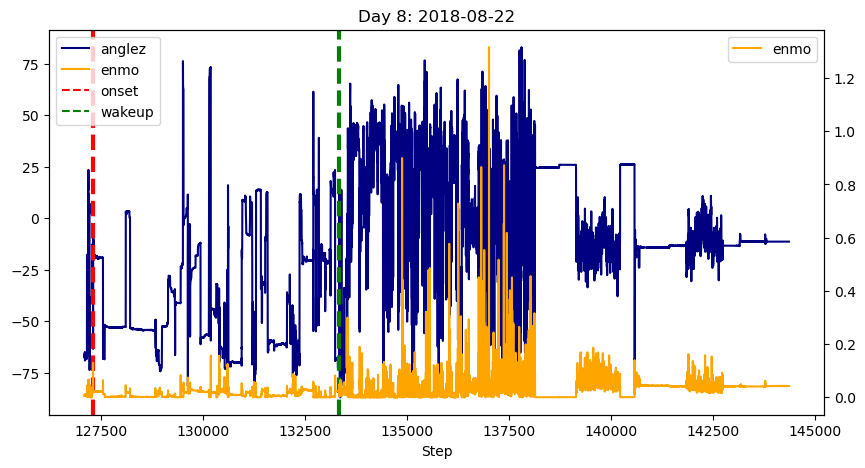

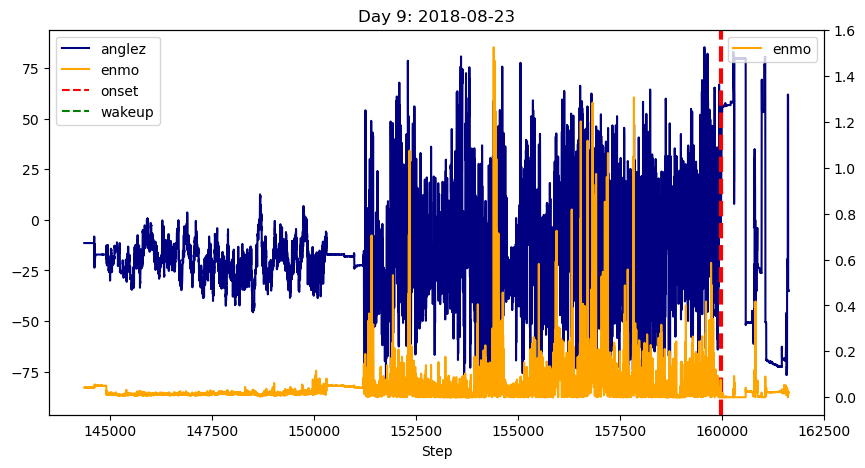

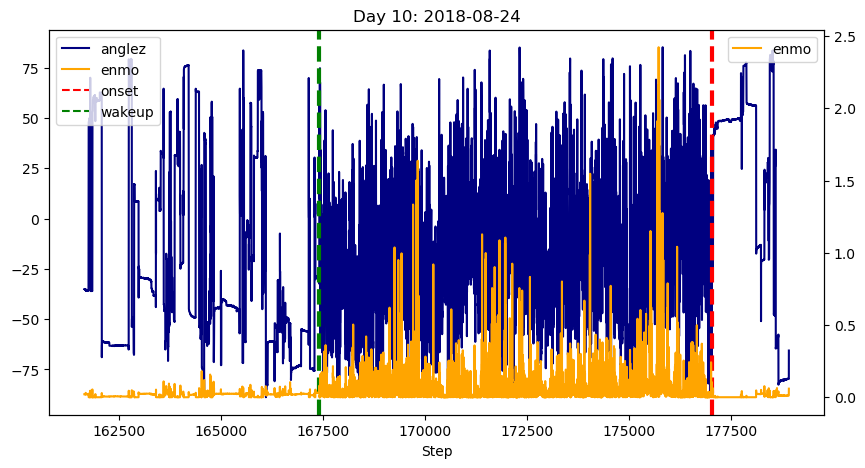

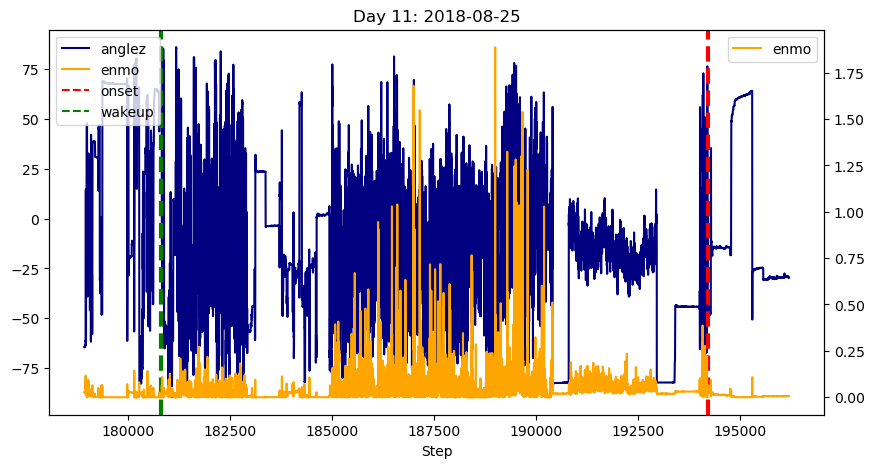

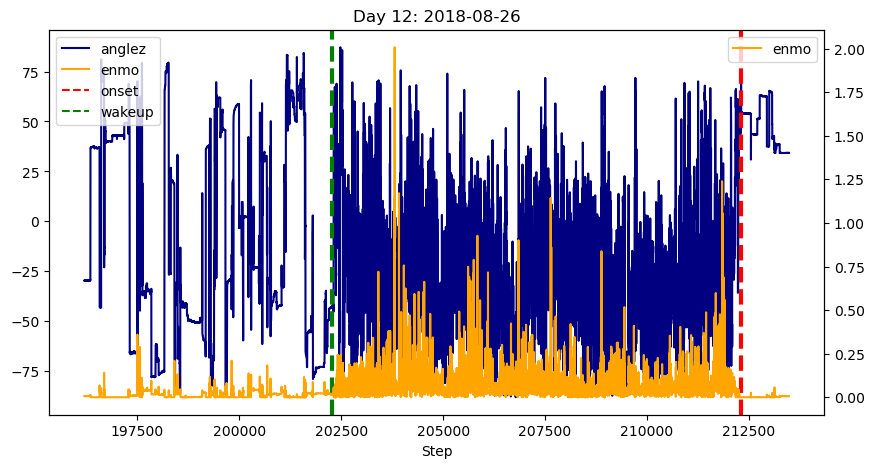

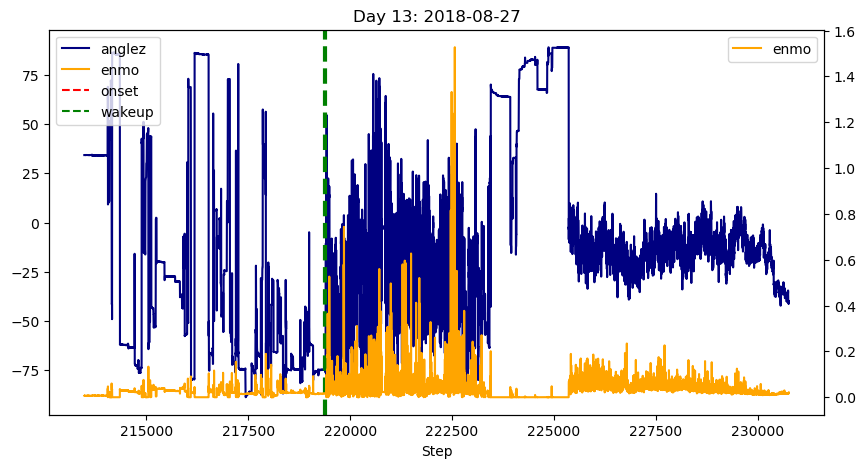

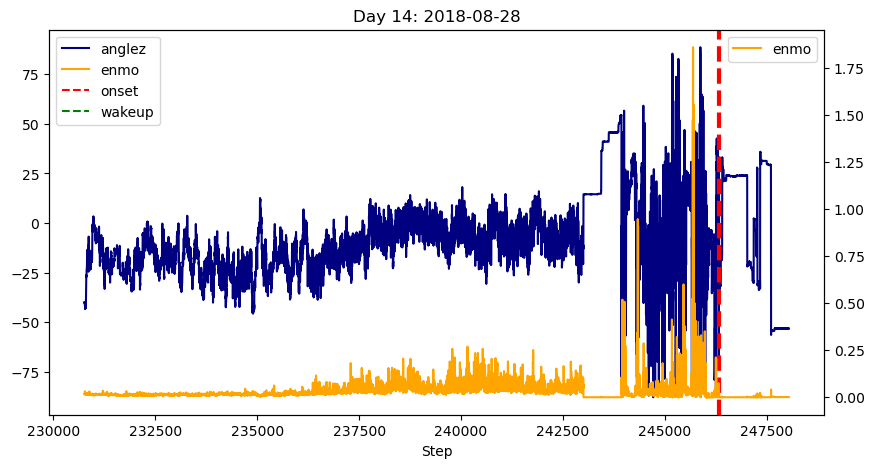

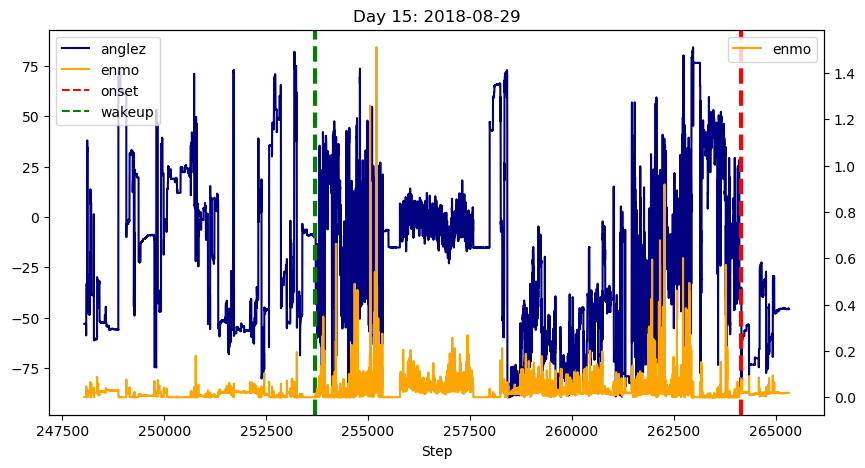

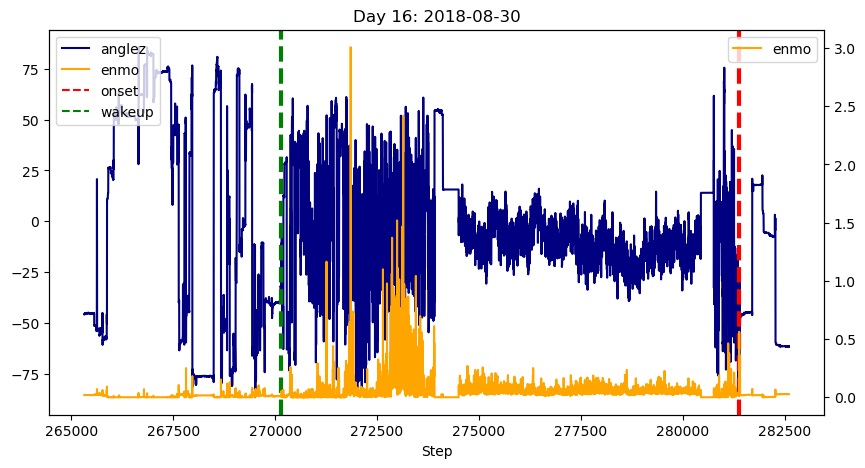

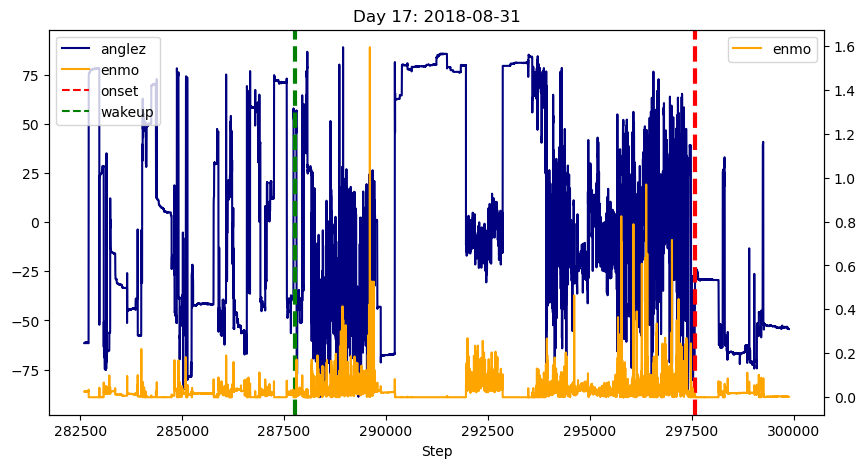

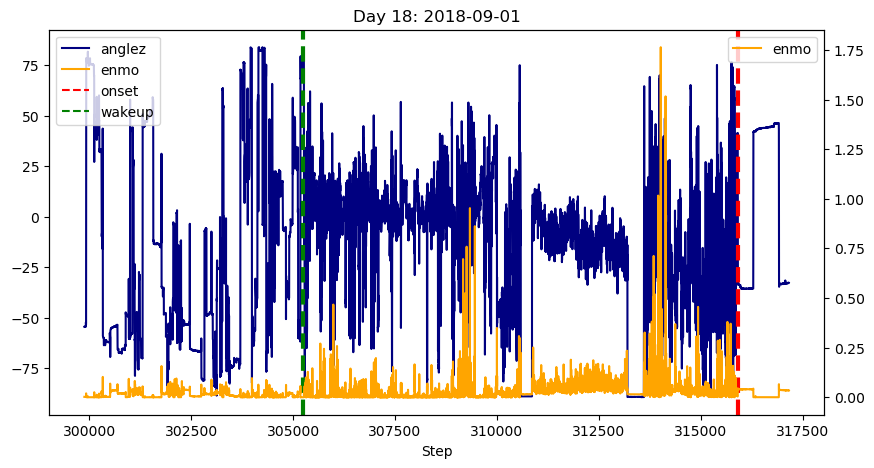

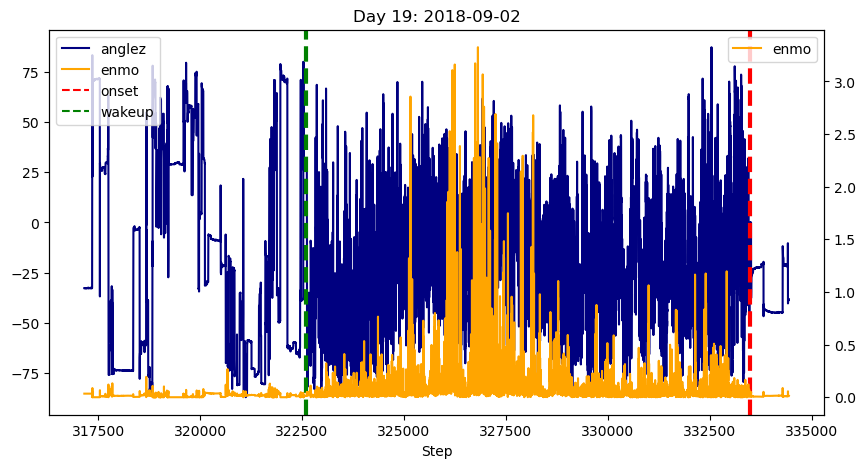

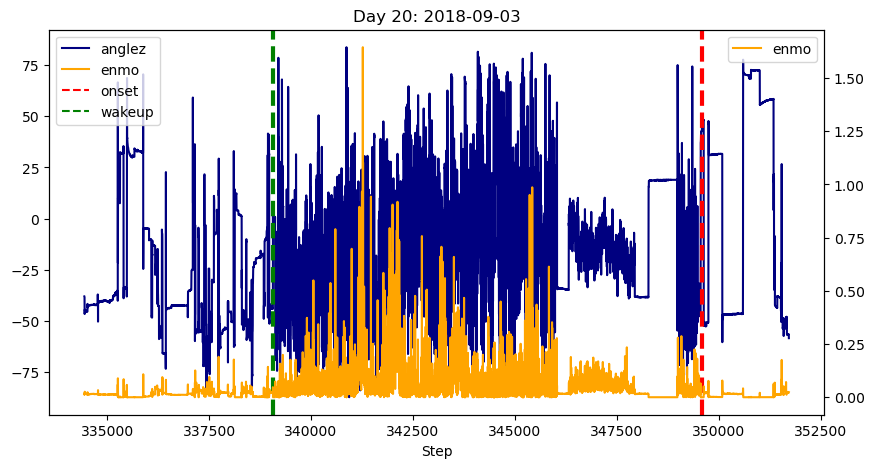

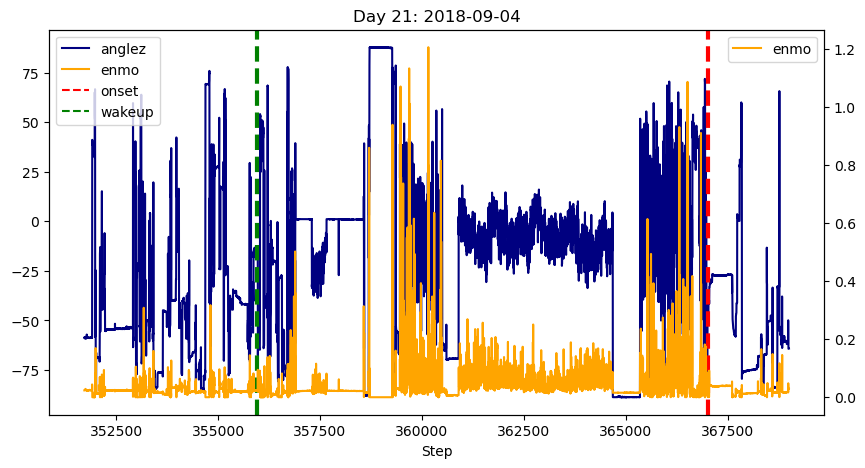

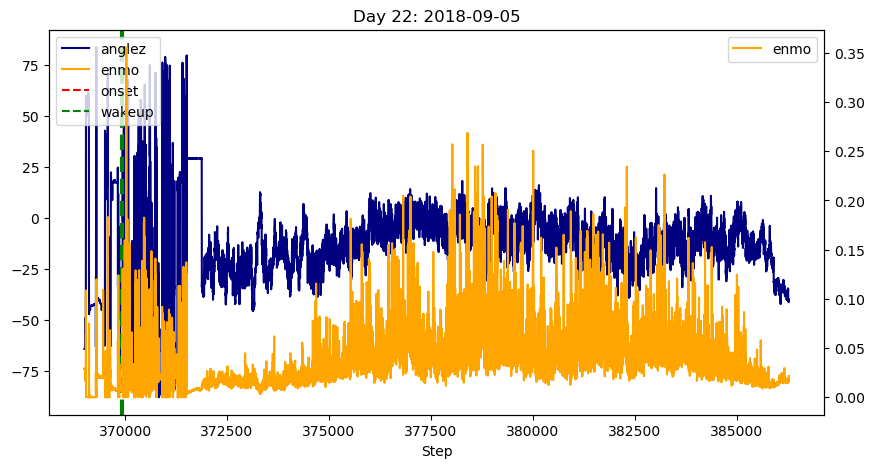

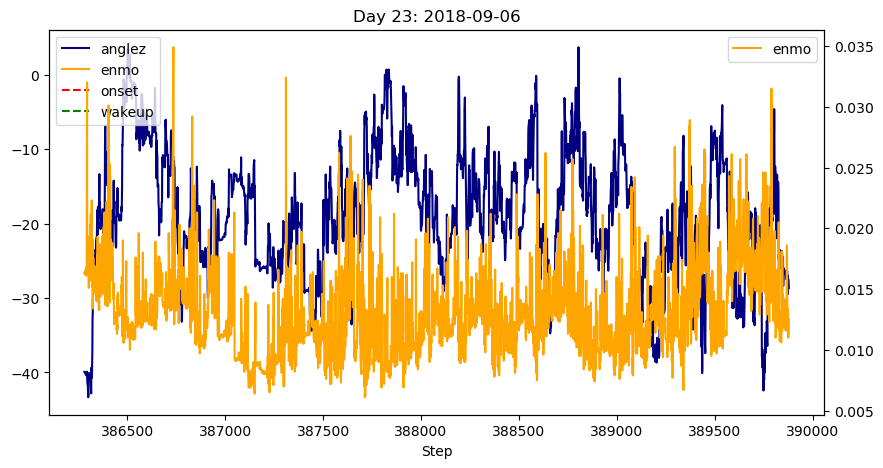

In [122]:
from matplotlib.lines import Line2D

# iterate through each date and row of data for the user
for i, (date, row) in enumerate(train_example.groupby('date')):

    # get first and last step for each date
    min_step = row['step'].min()
    max_step = row['step'].max()

    # get user id
    user_id = row[['series_id']].values[0][0]

    # plot anglez
    fig, ax = plt.subplots(figsize=(10, 5))
    row.set_index('step')[['anglez']].plot(ax=ax, title=f'Day {i}: {date}', color='navy', label='anglez')
    ax.set_xlabel('Step')

    # plot enmo
    ax2 = ax.twinx()
    row.set_index('step')[['enmo']].plot(ax=ax2, color='orange', label='enmo')

    # get the onset and wakeup events for the day
    user_events = events.loc[(events['series_id'] == user_id) & (events['step'] >= min_step) & (events['step'] <= max_step)].reset_index(drop=True)

    # plot vertical lines for events
    onset_lines = []
    wakeup_lines = []
    for index, event in user_events.iterrows():
        if event['event'] == 'onset' and not onset_lines:
            ax.axvline(x=event['step'], color='red', linestyle='--', linewidth=3, label='onset')
            onset_lines.append(event['step'])
        elif event['event'] == 'wakeup' and not wakeup_lines:
            ax.axvline(x=event['step'], color='green', linestyle='--', linewidth=3, label='wakeup')
            wakeup_lines.append(event['step'])
        else:
            ax.axvline(x=event['step'], color='red' if event['event'] == 'onset' else 'green', linestyle='--', linewidth=3)
    
    # custom legends
    legend_elements = [Line2D([0], [0], color='navy', label='anglez'),
                       Line2D([0], [0], color='orange', label='enmo'),
                       Line2D([0], [0], color='red', linestyle='--', label='onset'),
                       Line2D([0], [0], color='green', linestyle='--', label='wakeup')]

    # add legend manually
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.show()